In [3]:
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
from IPython import display

In [4]:
class UNetModel(nn.Module):

    def __init__(self,input_channels=3,output_channels=3):
        super().__init__()
        self.layer1 = self.defineFirstLayer(input_channels)
        self.layer2 = self.defineSecondLayer()
        self.layer3 = self.defineThirdLayer()
        self.layer4 = self.defineFourthLayer()
        self.layer5 = self.defineFifthLayer()
        self.upCov1 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.layer6 = self.defineSixthLayer()
        self.upCov2 = nn.ConvTranspose2d(64,32,kernel_size=2,stride=2)
        self.layer7 = self.defineSeventhLayer()
        self.upCov3 = nn.ConvTranspose2d(32,16,kernel_size=2,stride=2)
        self.layer8 = self.defineEighthLayer()
        self.upCov4 = nn.ConvTranspose2d(16,8,kernel_size=2,stride=2)
        self.layer9 = self.defineNinthLayer(output_channels)
    
    def defineFirstLayer(self,input_channels):
        return nn.Sequential(
            nn.Conv2d(input_channels,8,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8,8,kernel_size=3),
            nn.ReLU()
        )
    
    def defineSecondLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(8,16,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16,16,kernel_size=3),
            nn.ReLU()
        )
    
    def defineThirdLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(16,32,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size=3),
            nn.ReLU()
        )
    
    def defineFourthLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(32,64,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3),
            nn.ReLU()
        )
    
    def defineFifthLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,128,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3),
            nn.ReLU()
        )

    def defineSixthLayer(self):
        return nn.Sequential(
            nn.Conv2d(128,64,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3),
            nn.ReLU()
        )
    
    
    def defineSeventhLayer(self):
        return nn.Sequential(
            nn.Conv2d(64,32,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size=3),
            nn.ReLU()
        )
    
    def defineEighthLayer(self):
        return nn.Sequential(
            nn.Conv2d(32,16,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16,16,kernel_size=3),
            nn.ReLU()
        )
    
    def defineNinthLayer(self,output_channels):
        return nn.Sequential(
            nn.Conv2d(16,8,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8,8,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8,output_channels,kernel_size=1)
        )
    
    def crop_and_cat(self,cropTensor,catTensor,crop_by=(4,4)):
        cropTensor = self.crop(cropTensor,crop_by)
        # print(cropTensor.shape)
        # print(catTensor.shape)
        return torch.cat((cropTensor, catTensor),dim=1)


    def crop(self,cropTensor,crop_by):
        # print(crop_by)
        match crop_by:
            case (16,17):
                return cropTensor[:,:,crop_by[0]:-crop_by[0]-1,crop_by[1]:-crop_by[1]+1] 
            case _:
                return cropTensor[:,:,crop_by[0]:-crop_by[0],crop_by[1]:-crop_by[1]]
    
    def forward(self,X):
        X1 = self.layer1(X)
        X2 = self.layer2(X1)
        X3 = self.layer3(X2)
        X4 = self.layer4(X3)
        X5 = self.layer5(X4)
        X5_with_upscale = self.crop_and_cat(X4,self.upCov1(X5),crop_by=(4,4))
        X6 = self.layer6(X5_with_upscale)  
        X6_with_upscale = self.crop_and_cat(X3,self.upCov2(X6),crop_by=(16,17))
        X7 = self.layer7(X6_with_upscale)  
        X7_with_upscale = self.crop_and_cat(X2,self.upCov3(X7),crop_by=(41,41))
        X8 = self.layer8(X7_with_upscale)  
        X8_with_upscale = self.crop_and_cat(X1,self.upCov4(X8),crop_by=(90,90))
        X9 = self.layer9(X8_with_upscale)  
        return X9

model = UNetModel(input_channels=3,output_channels=3)
X = torch.rand(size=(1, 3, 256, 256), dtype=torch.float32)
model(X).shape

torch.Size([1, 3, 68, 68])

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.CenterCrop((120,90)),
        # transforms.Pad(70),
        # transforms.Resize((256,256))
    ]
)

train = torchvision.datasets.CelebA(root="../data", split='train', transform=transform, download=True)
test = torchvision.datasets.CelebA(root="../data", split='test', transform=transform, download=True) 

class LazyDataLoader:

    def __init__(self, dataset, batch_size=10, shuffle=False, num_workers=0):
        self.dataset = dataset
        self.batch_size = batch_size
        # self.shuffle = shuffle
        self.num_workers = num_workers
        self.total_batches = len(dataset)//batch_size + (0 if len(dataset)%batch_size == 0 else 1)
        self.extras = 0 if len(dataset)%batch_size == 0 else len(dataset)%batch_size
        self.label_map = dict()
        self.outputTransform = transforms.Compose([transforms.CenterCrop((120,90)),
                                                   transforms.Resize((68,68))])
        self.inputTransform = transforms.Compose([
                                            # transforms.CenterCrop((120,90)),
                                            transforms.Pad(padding=(80,85,80,95)),
                                            transforms.Resize((256,256))])
    
    def __len__(self):
        return self.total_batches
    
    def __iter__(self):
        counter = np.arange(self.total_batches*self.batch_size)
        np.random.shuffle(counter)
        self.counter = counter.reshape((self.total_batches,self.batch_size,-1))
        # print('batch-shape : ',self.counter.shape)
        self.current_batch = 0
        return self
    
    def fetch_data(self, index):
      image,_ = self.dataset[index[0]]
      inputImage = self.inputTransform(image)
      outputImage = self.outputTransform(image)
      return (inputImage,outputImage)
    
    def __next__(self):
        if self.current_batch >= self.counter.shape[0]:
            raise StopIteration
        x_all = []
        y_all = []
        for i in self.counter[self.current_batch]:
            if i >= len(self.dataset):
                continue
            x,y = self.fetch_data(i)
            x_all.append(x)
            y_all.append(y)
        self.current_batch += 1
        return torch.stack(x_all),torch.stack(y_all)
    
train_iter = LazyDataLoader(train, 500,shuffle=True)

# for i,(x,y) in enumerate(train_iter):
#     if i>=5:
#         break
#     plt.subplot(2,5,i+1)
#     plt.imshow(x[0].permute(1,2,0))
#     plt.subplot(2,5,i+6)
#     plt.imshow(y[0].permute(1,2,0))
    
# plt.show()
# test_iter = DataLoader(test, 1000)
# print(len(train_iter))

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for i,(x, y) in enumerate(zip(self.X, self.Y)):
            if y:
                if i==0:
                    self.axes[0].plot(x, y, self.fmts[0])
                else:
                    self.axes[0].plot(x, y, self.fmts[1])
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [7]:
def train(net, train_iter, num_epochs, lr):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)

  net.apply(init_weights)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.0005)
  loss = nn.MSELoss(reduction='mean')
  total_batches = len(train_iter)
  animator = Animator(
        xlabel=f'DataPerEpoch {num_epochs}epochs x {total_batches} batches', 
              xlim=[1, num_epochs*total_batches], ylim=[0, 0.04], legend=["training loss"]
    )
  for epoch in range(num_epochs):
    net.train()
    for i, (X,y) in enumerate(train_iter):
      optimizer.zero_grad()
      y_hat = net(X)
      l = loss(y_hat,y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        if l>=0.04:
          print(f'{epoch*total_batches + (i + 1)} : {l}')
        else:
          animator.add(epoch*total_batches + (i + 1), (l,None)) 
    torch.save(model, f'./unet_small/unet_param_celeba_mse_with_proper_crop_{epoch}.pt')


In [ ]:
def train(net, train_iter, num_epochs, lr):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)

  net.apply(init_weights)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.0005)
  loss = nn.MSELoss(reduction='mean')
  total_batches = len(train_iter)
  animator = Animator(
        xlabel=f'DataPerEpoch {num_epochs}epochs x {total_batches} batches', 
              xlim=[1, num_epochs*total_batches], ylim=[0, 0.04], legend=["training loss"]
    )
  for epoch in range(num_epochs):
    net.train()
    for i, (X,y) in enumerate(train_iter):
      optimizer.zero_grad()
      y_hat = net(X)
      l = loss(y_hat,y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        if l>=0.04:
          print(f'{epoch*total_batches + (i + 1)} : {l}')
        else:
          animator.add(epoch*total_batches + (i + 1), (l,None)) 
    torch.save(model, f'./unet_small/unet_param_celeba_mse_with_proper_crop_{epoch}.pt')


In [8]:
# model = torch.load('./unet_param_celeba_mse_with_proper_crop.pt')
# lr, num_epochs = 0.007, 10
# # model = torch.load('./unet_param_celeba_mse.pt')
# train(model, train_iter, num_epochs, lr)

# model = torch.load('./unet_small/unet_param_celeba_mse_with_proper_crop_9.pt')
# lr, num_epochs = 0.002, 2
# # model = torch.load('./unet_param_celeba_mse.pt')
# train(model, train_iter, num_epochs, lr)

In [133]:
# torch.save(model, './unet_param_celeba_mse_with_proper_crop_final.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


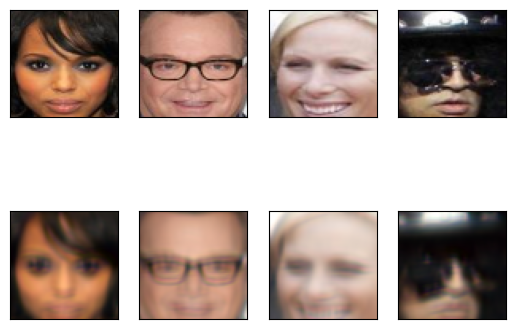

In [11]:
import random
model = torch.load('./unet_param_celeba_mse_with_proper_crop_final.pt')
model.eval()
test_iter = LazyDataLoader(test, 1000,shuffle=True)
for i,(X,y) in enumerate(test_iter):
    if i>=4:
        break
    index = random.randint(0,X.shape[0])
    image = X[index]
    model_input = torch.unsqueeze(image,dim=0)
    with torch.no_grad():
        result = model(model_input)[0]
        plt.subplot(2, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(y[index].permute(1,2,0))
        plt.subplot(2, 4, i+5)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(result.permute(1,2,0))
        
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0, 0.008023194968700409, 0.008023194968700409


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1, 0.01228407770395279, 0.01228407770395279
2, 0.0031624252442270517, 0.0031624252442270517


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3, 0.009833833202719688, 0.009833833202719688


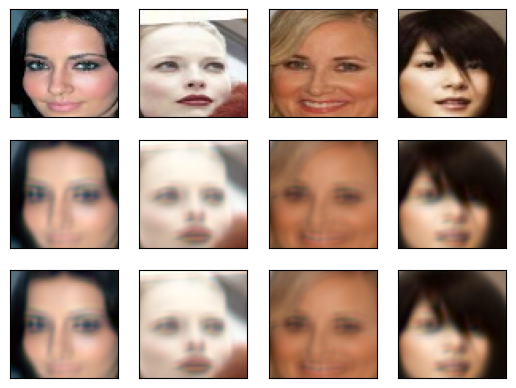

In [12]:
import random
model2 = torch.load('./unet_param_celeba_mse_with_proper_crop_final.pt')
model2.eval()
test_iter = LazyDataLoader(test, 1000,shuffle=True)
loss = nn.MSELoss(reduction='mean')
for i,(X,y) in enumerate(test_iter):
    if i>=4:
        break
    index = random.randint(0,X.shape[0])
    image = X[index]
    model_input = torch.unsqueeze(image,dim=0)
    with torch.no_grad():
        result = model2(model_input)[0]
        plt.subplot(3, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(y[index].permute(1,2,0))
        plt.subplot(3, 4, i+5)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(result.permute(1,2,0))
        result1 = model(model_input)[0]
        plt.subplot(3, 4, i+9)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(result1.permute(1,2,0))
        print(f'{i}, {loss(result,y[index])}, {loss(result1,y[index])}')
    
plt.show()

epoch : 0, batch per epoch : 0, Y : 0.06607279181480408
epoch : 0, batch per epoch : 0, Y : 0.2909037470817566
epoch : 0, batch per epoch : 0, Y : 0.007301113102585077
epoch : 0, batch per epoch : 0, Y : 0.12563873827457428
epoch : 0, batch per epoch : 0, Y : 0.06338629126548767
epoch : 0, batch per epoch : 0, Y : 0.12046880275011063
epoch : 0, batch per epoch : 0, Y : 0.19467803835868835
tensor([0.0868], grad_fn=<DivBackward0>)

epoch : 0, batch per epoch : 0, Y : 0.025685882195830345
epoch : 0, batch per epoch : 0, Y : 0.10147272050380707
epoch : 0, batch per epoch : 0, Y : 0.007233690936118364
epoch : 0, batch per epoch : 0, Y : 0.004848667420446873
epoch : 0, batch per epoch : 0, Y : 0.004845011048018932
epoch : 0, batch per epoch : 0, Y : 0.06820975989103317
epoch : 0, batch per epoch : 0, Y : 0.17603585124015808
tensor([0.0388], grad_fn=<DivBackward0>)

epoch : 0, batch per epoch : 0, Y : 0.05648422613739967
epoch : 0, batch per epoch : 0, Y : 0.03852042555809021
epoch : 0, batch per epoch : 0, Y : 0.039127983152866364
epoch : 0, batch per epoch : 0, Y : 0.022580832242965698
epoch : 0, batch per epoch : 0, Y : 0.042607951909303665
epoch : 0, batch per epoch : 0, Y : 0.15859293937683105
epoch : 0, batch per epoch : 0, Y : 0.07091289758682251
tensor([0.0429], grad_fn=<DivBackward0>)

epoch : 0, batch per epoch : 0, Y : 0.006026414688676596
epoch : 0, batch per epoch : 0, Y : 0.023597370833158493
epoch : 0, batch per epoch : 0, Y : 0.10080236941576004
epoch : 0, batch per epoch : 0, Y : 0.006436562165617943
epoch : 0, batch per epoch : 0, Y : 0.04143254831433296
epoch : 0, batch per epoch : 0, Y : 0.006315445527434349
epoch : 0, batch per epoch : 0, Y : 0.01111914124339819
tensor([0.0196], grad_fn=<DivBackward0>)

epoch : 0, batch per epoch : 0, Y : 0.005299033131450415
epoch : 0, batch per epoch : 0, Y : 0.040548600256443024
epoch : 0, batch per epoch : 0, Y : 0.16336983442306519
epoch : 0, batch per epoch : 0, Y : 0.01756376214325428
epoch : 0, batch per epoch : 0, Y : 0.009459301829338074
epoch : 0, batch per epoch : 0, Y : 0.00499036256223917
epoch : 0, batch per epoch : 0, Y : 0.19635295867919922
tensor([0.0438], grad_fn=<DivBackward0>)

epoch : 0, batch per epoch : 0, Y : 0.02695949748158455
epoch : 0, batch per epoch : 0, Y : 0.012122327461838722
epoch : 0, batch per epoch : 0, Y : 0.132175013422966
epoch : 0, batch per epoch : 0, Y : 0.13024772703647614
epoch : 0, batch per epoch : 0, Y : 0.020091138780117035
epoch : 0, batch per epoch : 0, Y : 0.05679721385240555
epoch : 0, batch per epoch : 0, Y : 0.07385918498039246
tensor([0.0452], grad_fn=<DivBackward0>)

